In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets as widgets
from statsmodels.tsa.stattools import adfuller
from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from tqdm import tqdm_notebook
from itertools import product
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
pd.options.mode.use_inf_as_na = True

%matplotlib inline

In [10]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])



In [14]:


#### Class to navigate to the csv data from jupyter stolen from https://gist.github.com/DrDub/6efba6e522302e43d055

class FileBrowser(object):
    def __init__(self):
        self.path = os.getcwd()
        self._update_files()
        
    def _update_files(self):
        self.files = list()
        self.dirs = list()
        if(os.path.isdir(self.path)):
            for f in os.listdir(self.path):
                ff = self.path + "/" + f
                if os.path.isdir(ff):
                    self.dirs.append(f)
                else:
                    self.files.append(f)
        
    def widget(self):
        box = widgets.VBox()
        self._update(box)
        return box
    
    def _update(self, box):
        
        def on_click(b):
            if b.description == '..':
                self.path = os.path.split(self.path)[0]
            else:
                self.path = self.path + "/" + b.description
            self._update_files()
            self._update(box)
        
        buttons = []
        if self.files:
            button = widgets.Button(description='..', background_color='#d0d0ff')
            button.on_click(on_click)
            buttons.append(button)
        for f in self.dirs:
            button = widgets.Button(description=f, background_color='#d0d0ff')
            button.on_click(on_click)
            buttons.append(button)
        for f in self.files:
            button = widgets.Button(description=f)
            button.on_click(on_click)
            buttons.append(button)
        box.children = tuple([widgets.HTML("<h2>%s</h2>" % (self.path,))] + buttons)

f = FileBrowser()
f.widget()

In [367]:
#### Loading the data and setting datetime index
def load_csv_data(path, timestamp_column):
    dataset = pd.read_csv(path, parse_dates=[timestamp_column])
    dataset = dataset.set_index(timestamp_column)
    dataset = dataset.apply(pd.to_numeric, errors='coerce', axis=0)
    dataset.drop_duplicates(inplace = True)
    dataset.sort_index(inplace=True)
    return dataset

#### Cleaning the dataset by filtering out outliers
def clean_dataset(dataset, column, levels=1):
    #### Selecting values that are less or equal 4 std from the mean
    if levels == 2:
        dataset = dataset[np.abs(dataset[column]-dataset[column].mean()) <= (4*dataset[column].std())]
        
    #### Selecting values by applying a rolling median filter
    elif levels == 3:
        dataset = dataset.rolling(5,center=True).median().fillna(method='bfill').fillna(method='ffill')
        
    #### IQR filtering (box and whisker style)
    elif levels ==4:
        q75, q25 = np.percentile(dataset[column].values, [75 ,25])
        iqr = q75 - q25
        l1 = np.percentile(dataset[column].values, 25) -  1.5 * iqr
        l3 = np.percentile(dataset[column].values, 75) +  1.5 * iqr
        dataset = dataset[(dataset[column] >= l1) 
              & (dataset[column] <= l3)]   
        
    #### Do no filtering
    elif levels == 1:
        pass
    
    else:
        print('Please specify cleaning level')
    
    dataset.sort_index(inplace=True)
    return dataset

#### Unit root test for stationarity
def test_stationarity(timeseries, column):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries[column], '.', color='blue',label='Original')
    mean = plt.plot(rolmean[column], '.', color='red', label='Rolling Mean')
    std = plt.plot(rolstd[column], '.', color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries[column], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

#### Detrending time series by taking the log and shifted differences
def detrending(dataset, column):
    ads_diff = np.log(dataset[column]) - np.log(dataset[column]).shift(1)
    ads_diff = ads_diff.fillna(method='bfill').fillna(method='ffill')
    return ads_diff

#### Calculating timeseries frequency
def add_freq(ts_dataset):
    freq = pd.infer_freq(ts_dataset.index)
    if not freq:
        start_index = 0
        date_diff = []
        for i in range(1, len(ts_dataset.index)):
            date_diff.append((ts_dataset.index[i] - ts_dataset.index[start_index]).total_seconds())
            start_index = i
        #### get mean frequency in minutes
        freq = np.round(np.ma.median(date_diff)/60)
        ts_dataset = ts_dataset[~ts_dataset.index.duplicated()]
        ts_dataset = ts_dataset.asfreq(freq='%imin'%freq)
        ts_dataset.fillna(method='ffill', inplace=True)
    else:
        ts_dataset = ts_dataset.asfreq(freq=freq)

    return ts_dataset



def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))


def plotHoltWinters(series, plot_intervals=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);


       

In [651]:
f = FileBrowser()
f.widget()

In [652]:
dataset.columns

Index(['ir temperature in ºC (SHT 31)', 'humidity in % (SHT 31)',
       'atmospheric pressure in kPa (MPL3115A25)', 'light in Lux (BH1730FVC)',
       'PM 1 in ug/m3 (PMS 5003)', 'PM 10 in ug/m3 (PMS 5003)',
       'PM 2.5 in ug/m3 (PMS 5003)', 'CO in kOhm (MICS 4514)',
       'NO2 in kOhm (MICS 4514)', 'battery in % (Battery SCK 2.0)'],
      dtype='object')

Index(['ir temperature in ºC (SHT 31)', 'humidity in % (SHT 31)',
       'atmospheric pressure in kPa (MPL3115A25)', 'light in Lux (BH1730FVC)',
       'PM 1 in ug/m3 (PMS 5003)', 'PM 10 in ug/m3 (PMS 5003)',
       'PM 2.5 in ug/m3 (PMS 5003)', 'CO in kOhm (MICS 4514)',
       'NO2 in kOhm (MICS 4514)', 'battery in % (Battery SCK 2.0)'],
      dtype='object')


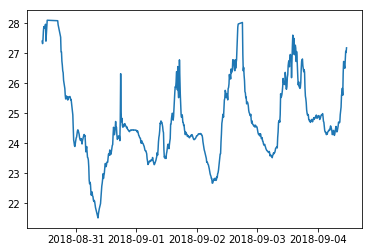

In [682]:
column = 'ir temperature in ºC (SHT 31)'
dataset = load_csv_data(f.path, 'timestamp')
print(dataset.columns)
cleaned = clean_dataset(dataset, column, 4)

plt.plot(cleaned[column])


Cleaned dataset with IQR filtering (box and whisker style)
testing for periodicity...
Found significant periodicity component at 5 frequency
Using Holt-Winters model
Optimising coefficients using cross validation
Optimising seaonal length using mean_squared_error
fitting mean squared error is: 0.3f
CPU times: user 4.45 s, sys: 18.6 ms, total: 4.47 s
Wall time: 4.47 s


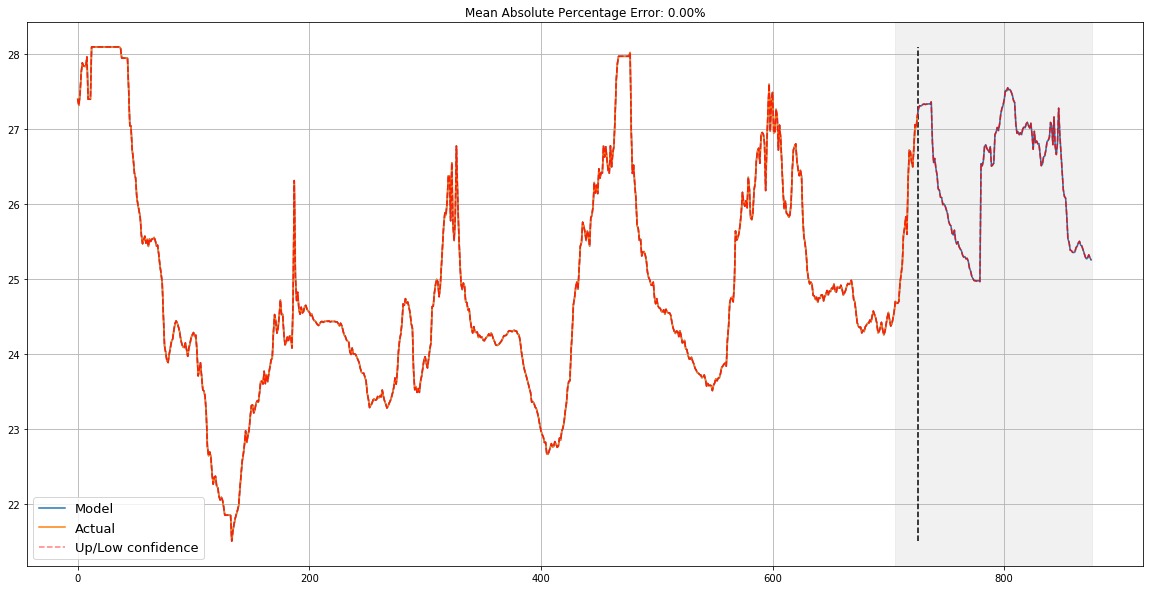

In [683]:
%%time

from scipy.special import comb
from scipy import signal
from scipy.optimize import least_squares

#### Clean dataset
cleaned = add_freq(cleaned)
print('Cleaned dataset with IQR filtering (box and whisker style)')
print('testing for periodicity...')

#### Test for periodicity. Using the periodogram https://onlinecourses.science.psu.edu/stat510/node/71/
p, fr = signal.periodogram(detrending(cleaned,column),len(cleaned))

#### Calculating fishers g statistic Fisher's. g-statistic is the ratio of the largest periodogram value to the sum of all the periodogram values over 1/2 of the frequency interval, (0, Fs/2). This interval
#### bound is the default one in signal.periodogram
index, value = (np.argmax(fr), max(fr))
fisher_g = fr[index]/sum(fr)

N = len(fr);
upper  = np.floor(1/fisher_g);
I = []

#### Formula from Wichert, Sofia, Konstantinos Fokianos, and Korbinian Strimmer. "Identifying Periodically Expressed Transcripts in Microarray Time Series Data." Bioinformatics. Vol. 20, 2004, pp. 5-20.
for nn in range(1,4):
    I.append((-1)**(nn-1)*comb(N,nn)*(1-nn*fisher_g)**(N-1))

pval = sum(I)

#### Testing for significance
if pval < 0.10:
    print('Found significant periodicity component at %i frequency'%p[index])
    print('Using Holt-Winters model')
    
    data = cleaned[column] 

    # initializing model parameters alpha, beta and gamma
    x = [0, 0, 0] 

    print('Optimising coefficients using cross validation')
    # Minimizing the loss function. Need to determine the season length for timeseriesCVscore
    opt = minimize(timeseriesCVscore, x0=x, 
                   args=(data), 
                   method=None, bounds = ((0, 1), (0, 1), (0, 1))
                  )


    alpha_final, beta_final, gamma_final = opt.x

    print('Optimising seaonal length using mean_squared_error')
    errors = []
    for x in np.arange(1,360, 7):
        model = HoltWinters(data, slen = int(x), 
                            alpha = alpha_final, 
                            beta = beta_final, 
                            gamma = gamma_final, 
                            n_preds = 0, scaling_factor = 2)
        model.triple_exponential_smoothing()

        error = mean_squared_error(data, model.result)
        errors.append(error)

    print('fitting mean squared error is: %i.3f' %error)


    model = HoltWinters(data, slen = np.arange(1,360, 7)[np.argmin(errors)], 
                        alpha = alpha_final, 
                        beta = beta_final, 
                        gamma = gamma_final, 
                        n_preds = 150, scaling_factor = 2)
    model.triple_exponential_smoothing()

    plotHoltWinters(cleaned[column], plot_intervals=True)
    
else:
    print('Your time series doesnt look like it contains a seasonal component. Would you like to use a time series approach anyway?')
    ### TODO

Test Absolute: 0.419


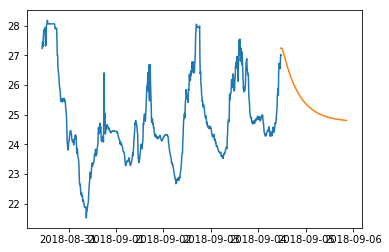

In [684]:
from statsmodels.tsa.ar_model import AR

y = cleaned[column].values
X = cleaned[column].index
model = AR(y)
model_fit = model.fit(maxlag=6, disp=False)
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = [y[i] for i in range(len(y))]
predictions = list()

# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat

for t in range(len(y)):
    yhat = predict(coef, history)
    obs = y[t]
    predictions.append(yhat)
    history.append(obs)
    
error = mean_absolute_percentage_error(y, predictions)
print('Test Absolute: %.3f' % error)

X_new = pd.date_range(cleaned[column].index[-1], periods=200, freq=cleaned[column].index.freq)

plt.plot(X,predictions)
plt.plot(X_new.values,model_fit.predict(start = cleaned.shape[0], end = cleaned.shape[0]+199))

# plt.plot( model_fit.predict(start = cleaned.shape[0], end = cleaned.shape[0]+11))
def plotAR(series):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
    """
    plt.figure(figsize=(20, 10)) 
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")